In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 2
commitnumber = d62b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

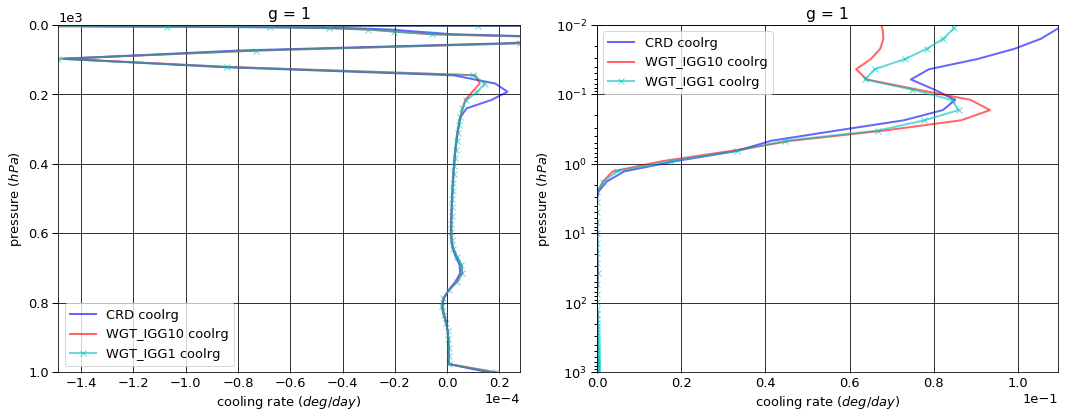

# Figure: cooling rate g-group 2

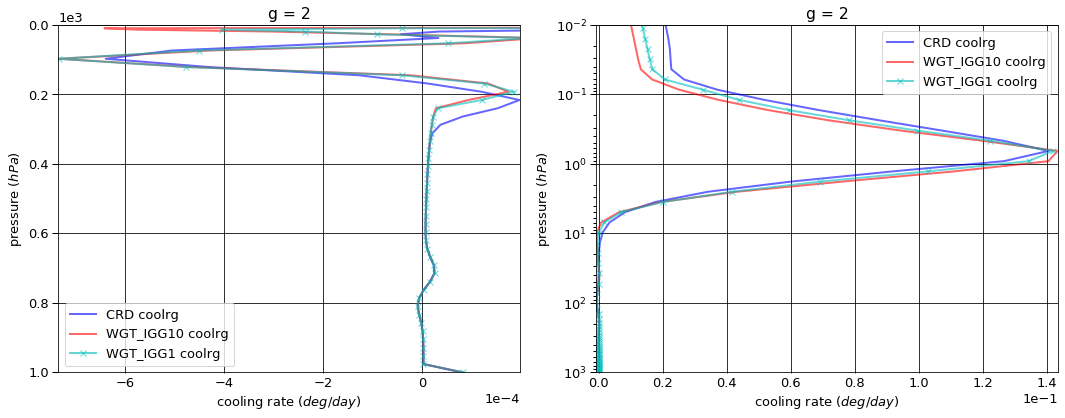

# Figure: cooling rate g-group 3

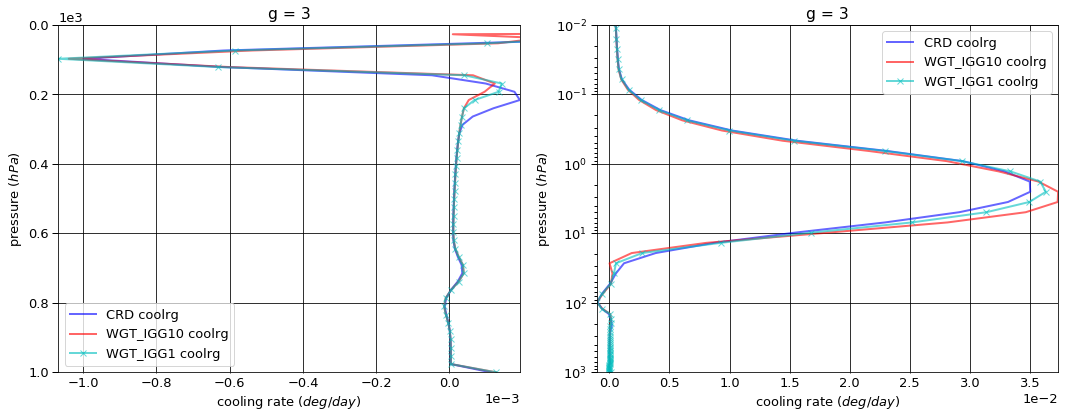

# Figure: cooling rate g-group 4

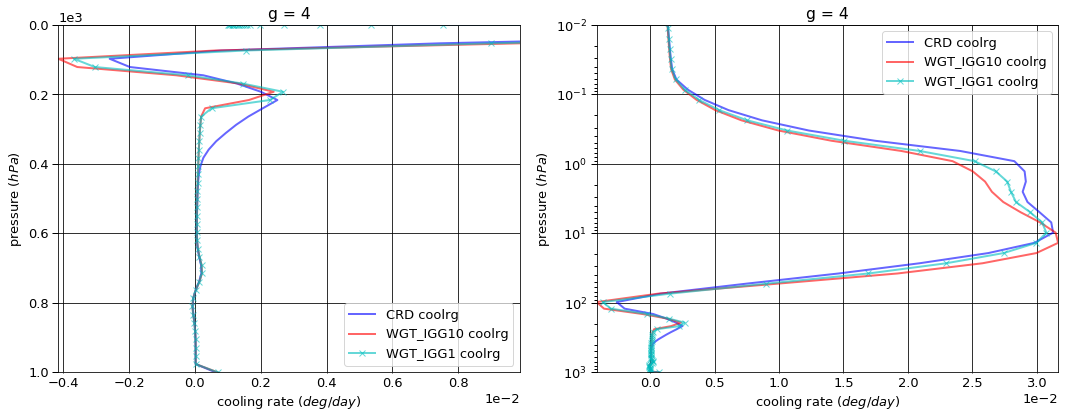

# Figure: cooling rate g-group 5

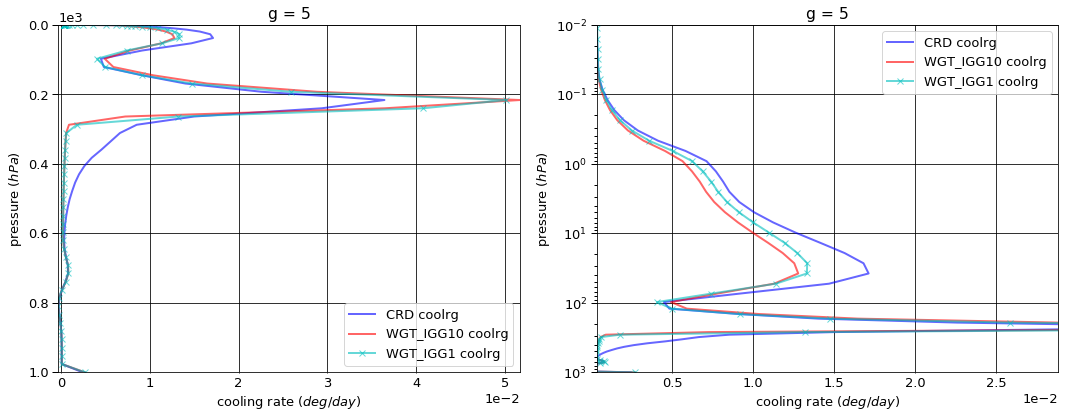

# Figure: cooling rate g-group 6

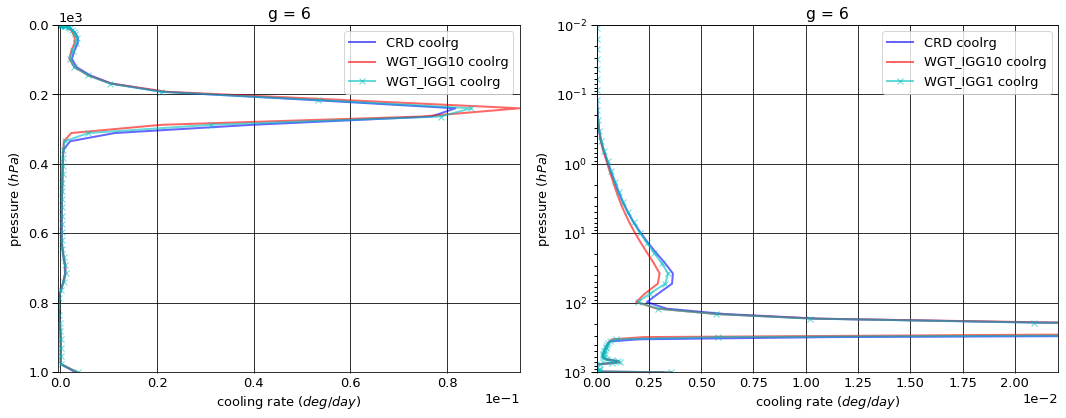

# Figure: cooling rate g-group 7

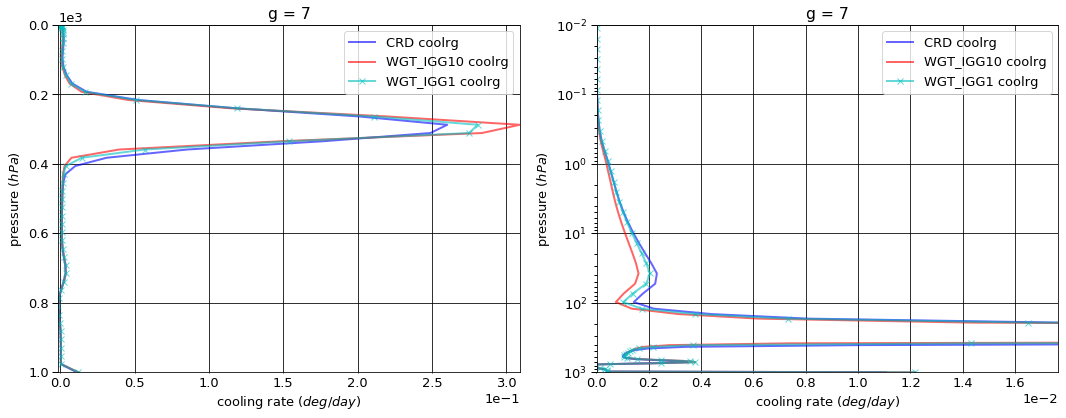

# Figure: cooling rate g-group 8

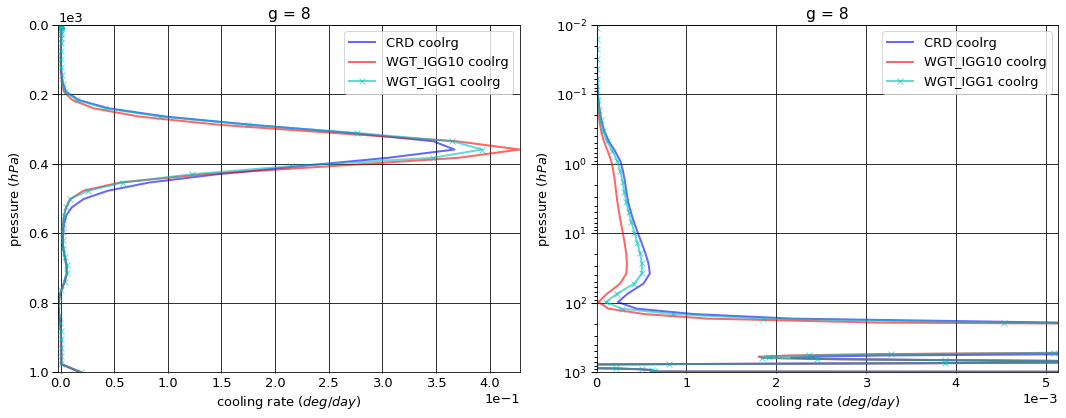

# Figure: cooling rate g-group 9

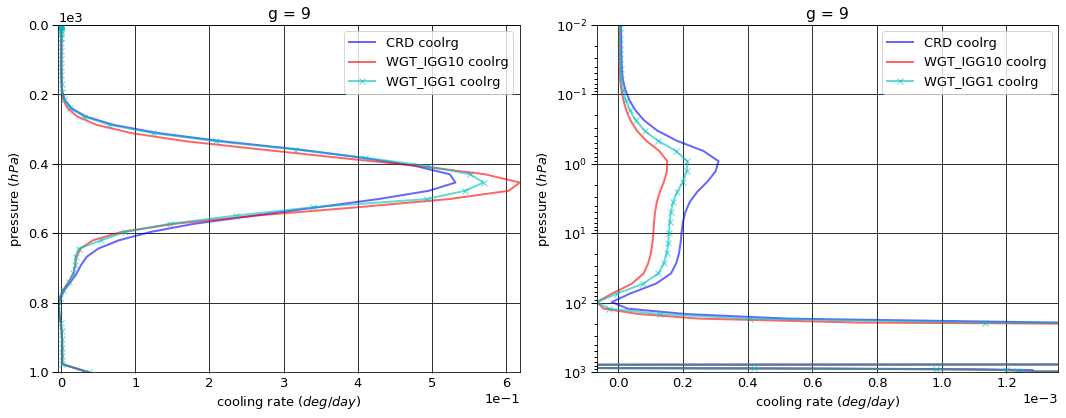

# Figure: cooling rate g-group 10

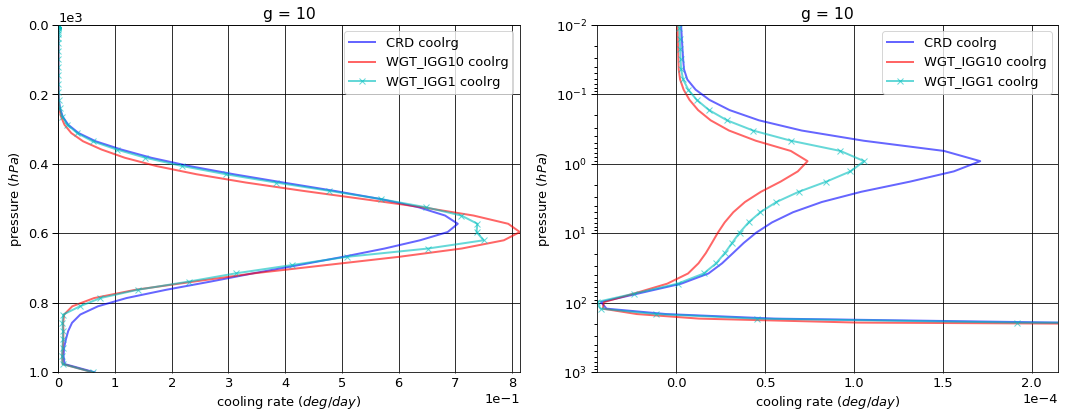

# Figure: cooling rate g-group 11

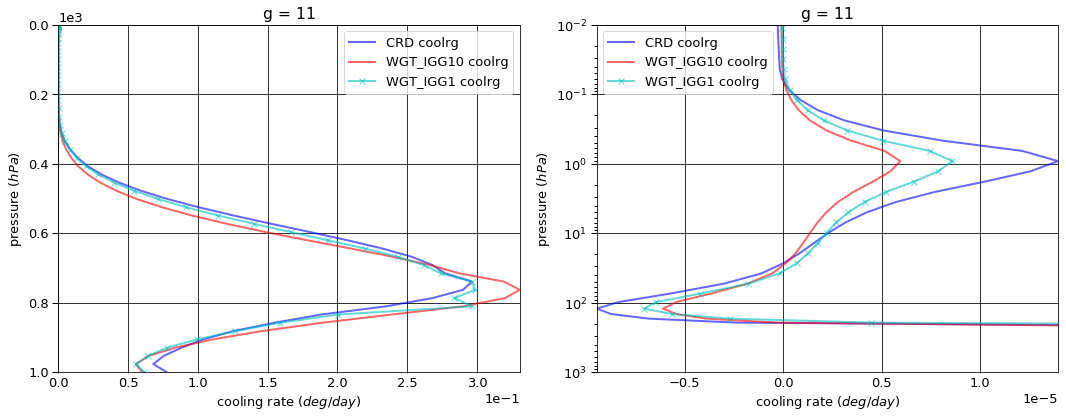

# Figure: cooling rate g-group total

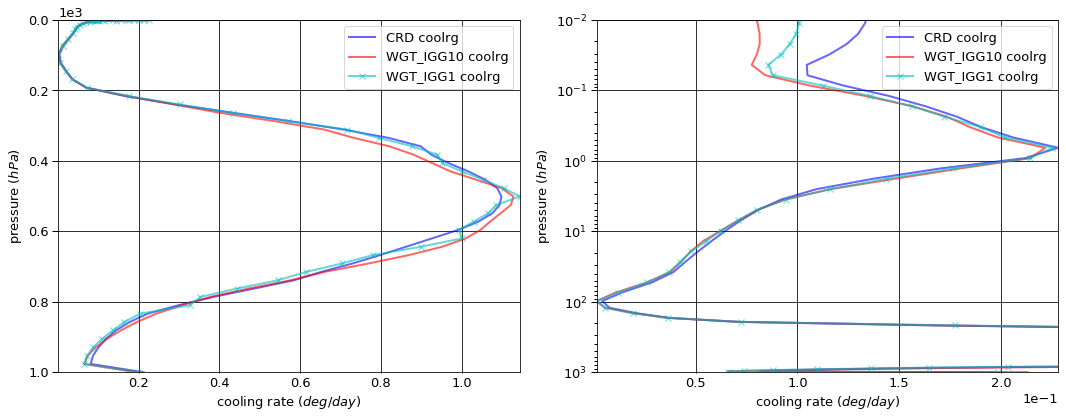

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005834   0.000000  -0.005834
   1013.0   76     -0.009730   0.009686  -0.000044
2  0.0      1      -0.029587   0.000000  -0.029587
   1013.0   76     -0.044436   0.044218  -0.000218
3  0.0      1      -0.039695   0.000000  -0.039695
   1013.0   76     -0.067355   0.067041  -0.000314
4  0.0      1      -0.170314   0.000000  -0.170314
   1013.0   76     -0.365879   0.364146  -0.001733
5  0.0      1      -0.650127   0.000000  -0.650127
   1013.0   76     -1.429126   1.422342  -0.006784
6  0.0      1      -0.936951   0.000000  -0.936951
   1013.0   76     -1.885778   1.876986  -0.008792
7  0.0      1      -3.582686   0.000000  -3.582686
   1013.0   76     -6.479185   6.448499  -0.030685
8  0.0      1      -6.298584   0.000000  -6.298584
   1013.0   76    -10.308642  10.259287  -0.049355
9  0.0      1     -13.689677   0.000000 -13.689677
   1013.0   76    -20.135346  20.036267  -0.099080
10 0.0      1     -23.915543   0.000000 -23.915543
   1013.0   76    -31.540371  31.353338  -0.187032
11 0.0      1     -11.845904   0.000000 -11.845904
   1013.0   76    -14.209382  13.724483  -0.484899


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005673   0.000000  -0.005673
   1013.0   76     -0.010261   0.010209  -0.000052
2  0.0      1      -0.030745   0.000000  -0.030745
   1013.0   76     -0.045048   0.044820  -0.000228
3  0.0      1      -0.040291   0.000000  -0.040291
   1013.0   76     -0.070012   0.069659  -0.000354
4  0.0      1      -0.159882   0.000000  -0.159882
   1013.0   76     -0.377360   0.375453  -0.001906
5  0.0      1      -0.599021   0.000000  -0.599021
   1013.0   76     -1.472836   1.465395  -0.007441
6  0.0      1      -0.901929   0.000000  -0.901929
   1013.0   76     -1.958963   1.949066  -0.009897
7  0.0      1      -3.521024   0.000000  -3.521024
   1013.0   76     -6.682441   6.648681  -0.033759
8  0.0      1      -6.298594   0.000000  -6.298594
   1013.0   76    -10.580144  10.526693  -0.053450
9  0.0      1     -13.779310   0.000000 -13.779310
   1013.0   76    -20.406826  20.303732  -0.103094
10 0.0      1     -24.029753   0.000000 -24.029753
   1013.0   76    -31.355088  31.185558  -0.169530
11 0.0      1     -11.573207   0.000000 -11.573207
   1013.0   76    -13.516252  13.249511  -0.266741


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005693   0.000000  -0.005693
   1013.0   76     -0.010261   0.010209  -0.000052
2  0.0      1      -0.030414   0.000000  -0.030414
   1013.0   76     -0.045048   0.044820  -0.000228
3  0.0      1      -0.039883   0.000000  -0.039883
   1013.0   76     -0.070012   0.069659  -0.000354
4  0.0      1      -0.159211   0.000000  -0.159211
   1013.0   76     -0.377360   0.375453  -0.001906
5  0.0      1      -0.607870   0.000000  -0.607870
   1013.0   76     -1.472836   1.465395  -0.007441
6  0.0      1      -0.908051   0.000000  -0.908051
   1013.0   76     -1.958963   1.949066  -0.009897
7  0.0      1      -3.520053   0.000000  -3.520053
   1013.0   76     -6.682441   6.648681  -0.033759
8  0.0      1      -6.244395   0.000000  -6.244395
   1013.0   76    -10.580144  10.526693  -0.053450
9  0.0      1     -13.654648   0.000000 -13.654648
   1013.0   76    -20.406826  20.303732  -0.103094
10 0.0      1     -23.796017   0.000000 -23.796017
   1013.0   76    -31.355088  31.183922  -0.171166
11 0.0      1     -11.469635   0.000000 -11.469635
   1013.0   76    -13.516252  13.229893  -0.286359


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000161  0.000000  0.000161
   1013.0   76    -0.000531  0.000523 -0.000008
2  0.0      1     -0.001158  0.000000 -0.001158
   1013.0   76    -0.000612  0.000602 -0.000009
3  0.0      1     -0.000596  0.000000 -0.000596
   1013.0   76    -0.002657  0.002617 -0.000040
4  0.0      1      0.010432  0.000000  0.010432
   1013.0   76    -0.011480  0.011307 -0.000173
5  0.0      1      0.051105  0.000000  0.051105
   1013.0   76    -0.043710  0.043054 -0.000657
6  0.0      1      0.035021  0.000000  0.035021
   1013.0   76    -0.073185  0.072080 -0.001105
7  0.0      1      0.061662  0.000000  0.061662
   1013.0   76    -0.203256  0.200182 -0.003074
8  0.0      1     -0.000010  0.000000 -0.000010
   1013.0   76    -0.271502  0.267406 -0.004095
9  0.0      1     -0.089633  0.000000 -0.089633
   1013.0   76    -0.271480  0.267465 -0.004014
10 0.0      1     -0.114210  0.000000 -0.114210
   1013.0   76     0.185283 -0.167780  0.017502
11 0.0      1      0.272697  0.000000  0.272697
   1013.0   76     0.693130 -0.474972  0.218158


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000141  0.000000  0.000141
   1013.0   76    -0.000531  0.000523 -0.000008
2  0.0      1     -0.000828  0.000000 -0.000828
   1013.0   76    -0.000612  0.000602 -0.000009
3  0.0      1     -0.000188  0.000000 -0.000188
   1013.0   76    -0.002657  0.002617 -0.000040
4  0.0      1      0.011103  0.000000  0.011103
   1013.0   76    -0.011480  0.011307 -0.000173
5  0.0      1      0.042257  0.000000  0.042257
   1013.0   76    -0.043710  0.043054 -0.000657
6  0.0      1      0.028900  0.000000  0.028900
   1013.0   76    -0.073185  0.072080 -0.001105
7  0.0      1      0.062633  0.000000  0.062633
   1013.0   76    -0.203256  0.200182 -0.003074
8  0.0      1      0.054189  0.000000  0.054189
   1013.0   76    -0.271502  0.267406 -0.004095
9  0.0      1      0.035029  0.000000  0.035029
   1013.0   76    -0.271480  0.267465 -0.004014
10 0.0      1      0.119526  0.000000  0.119526
   1013.0   76     0.185283 -0.169416  0.015866
11 0.0      1      0.376269  0.000000  0.376269
   1013.0   76     0.693130 -0.494590  0.198540

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.035992e-01
   1001.112500 75     1.582630e-05
2  0.000312    1      1.378225e-02
   1001.112500 75     7.870260e-05
3  0.000312    1      3.027371e-04
   1001.112500 75     1.131651e-04
4  0.000312    1      9.545462e-04
   1001.112500 75     6.252163e-04
5  0.000312    1      2.425859e-04
   1001.112500 75     2.447076e-03
6  0.000312    1      1.419899e-06
   1001.112500 75     3.172471e-03
7  0.000312    1      4.306357e-06
   1001.112500 75     1.107049e-02
8  0.000312    1      5.033517e-06
   1001.112500 75     1.780349e-02
9  0.000312    1      5.134061e-06
   1001.112500 75     3.573134e-02
10 0.000312    1      4.145214e-07
   1001.112500 75     6.418670e-02
11 0.000312    1     -4.171152e-07
   1001.112500 75     7.781918e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      5.217992e-02
   1001.112500 75     1.868793e-05
2  0.000312    1      5.036521e-03
   1001.112500 75     8.204357e-05
3  0.000312    1      3.186738e-04
   1001.112500 75     1.275099e-04
4  0.000312    1      1.011632e-03
   1001.112500 75     6.872655e-04
5  0.000312    1      2.588013e-04
   1001.112500 75     2.682401e-03
6  0.000312    1      1.187357e-06
   1001.112500 75     3.567758e-03
7  0.000312    1      3.089493e-06
   1001.112500 75     1.217039e-02
8  0.000312    1      2.173175e-06
   1001.112500 75     1.926907e-02
9  0.000312    1      1.742263e-06
   1001.112500 75     3.716593e-02
10 0.000312    1     -3.013085e-07
   1001.112500 75     6.067333e-02
11 0.000312    1     -1.503421e-07
   1001.112500 75     6.021450e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      7.219391e-02
   1001.112500 75     1.868793e-05
2  0.000312    1      7.786483e-03
   1001.112500 75     8.204357e-05
3  0.000312    1      3.116268e-04
   1001.112500 75     1.275099e-04
4  0.000312    1      1.019783e-03
   1001.112500 75     6.872655e-04
5  0.000312    1      2.861110e-04
   1001.112500 75     2.682401e-03
6  0.000312    1      1.377751e-06
   1001.112500 75     3.567758e-03
7  0.000312    1      4.017141e-06
   1001.112500 75     1.217039e-02
8  0.000312    1      3.435556e-06
   1001.112500 75     1.926907e-02
9  0.000312    1      3.080403e-06
   1001.112500 75     3.716590e-02
10 0.000312    1      2.851696e-07
   1001.112500 75     6.082132e-02
11 0.000312    1     -1.416482e-07
   1001.112500 75     6.164941e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.141924e-02
   1001.112500 75     2.861627e-06
2  0.000312    1     -8.745729e-03
   1001.112500 75     3.340967e-06
3  0.000312    1      1.593669e-05
   1001.112500 75     1.434478e-05
4  0.000312    1      5.708615e-05
   1001.112500 75     6.204916e-05
5  0.000312    1      1.621537e-05
   1001.112500 75     2.353251e-04
6  0.000312    1     -2.325424e-07
   1001.112500 75     3.952871e-04
7  0.000312    1     -1.216864e-06
   1001.112500 75     1.099898e-03
8  0.000312    1     -2.860342e-06
   1001.112500 75     1.465578e-03
9  0.000312    1     -3.391798e-06
   1001.112500 75     1.434594e-03
10 0.000312    1     -7.158299e-07
   1001.112500 75    -3.513366e-03
11 0.000312    1      2.667731e-07
   1001.112500 75    -1.760468e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.140525e-02
   1001.112500 75     2.861627e-06
2  0.000312    1     -5.995767e-03
   1001.112500 75     3.340967e-06
3  0.000312    1      8.889730e-06
   1001.112500 75     1.434478e-05
4  0.000312    1      6.523625e-05
   1001.112500 75     6.204916e-05
5  0.000312    1      4.352511e-05
   1001.112500 75     2.353251e-04
6  0.000312    1     -4.214860e-08
   1001.112500 75     3.952871e-04
7  0.000312    1     -2.892164e-07
   1001.112500 75     1.099898e-03
8  0.000312    1     -1.597961e-06
   1001.112500 75     1.465578e-03
9  0.000312    1     -2.053658e-06
   1001.112500 75     1.434568e-03
10 0.000312    1     -1.293518e-07
   1001.112500 75    -3.365374e-03
11 0.000312    1      2.754670e-07
   1001.112500 75    -1.616977e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.164902,0.000000,-61.164902
1013.0,76,-86.475231,85.606295,-0.868936



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.93943,0.000000,-60.939430
1013.0,76,-86.47523,85.828778,-0.646452



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.43587,0.000000,-60.435870
1013.0,76,-86.47523,85.807524,-0.667705



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.254718e-01,0.000000,0.225472
1013.0,76,2.292000e-07,0.222484,0.222484



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.290315e-01,0.00000,0.729031
1013.0,76,2.292000e-07,0.20123,0.201231


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.118897
1001.112500,75,0.213064



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.058813
1001.112500,75,0.196659



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.081610
1001.112500,75,0.198242



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.060084
1001.112500,75,-0.016405



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.037287
1001.112500,75,-0.014822


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
